Enter activity levels (0.0–1.0):

– Morning


  Living_Room:  .1
  Kitchen:  .5
  Room:  .1
  Bedroom:  .4
  Toilet:  .8
  Bathroom:  .8
  Gym:  .9



– Afternoon


  Living_Room:  .1
  Kitchen:  0
  Room:  0
  Bedroom:  .1
  Toilet:  .4
  Bathroom:  .4
  Gym:  .9



– Evening


  Living_Room:  1
  Kitchen:  .8
  Room:  .2
  Bedroom:  .1
  Toilet:  .3
  Bathroom:  .3
  Gym:  .9



– Night


  Living_Room:  0
  Kitchen:  0
  Room:  0
  Bedroom:  1
  Toilet:  .3
  Bathroom:  .3
  Gym:  0



Final activity levels:
{'Afternoon': {'Bathroom': 0.4,
               'Bedroom': 0.1,
               'Gym': 0.9,
               'Kitchen': 0.0,
               'Living_Room': 0.1,
               'Room': 0.0,
               'Toilet': 0.4},
 'Evening': {'Bathroom': 0.3,
             'Bedroom': 0.1,
             'Gym': 0.9,
             'Kitchen': 0.8,
             'Living_Room': 1.0,
             'Room': 0.2,
             'Toilet': 0.3},
 'Morning': {'Bathroom': 0.8,
             'Bedroom': 0.4,
             'Gym': 0.9,
             'Kitchen': 0.5,
             'Living_Room': 0.1,
             'Room': 0.1,
             'Toilet': 0.8},
 'Night': {'Bathroom': 0.3,
           'Bedroom': 1.0,
           'Gym': 0.0,
           'Kitchen': 0.0,
           'Living_Room': 0.0,
           'Room': 0.0,
           'Toilet': 0.3}}
Time slot 'Morning': PSO+GA runtime = 0.84s
Time slot 'Afternoon': PSO+GA runtime = 0.83s
Time slot 'Evening': PSO+GA runtime = 0.84s
Time slot 'Night': PSO+GA runtime = 0.

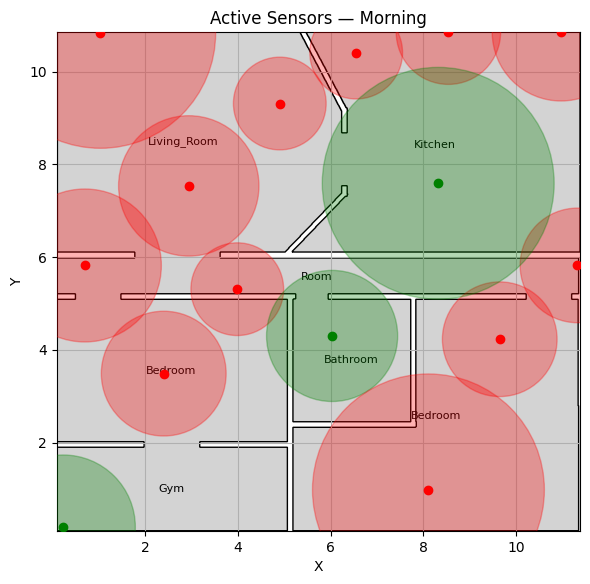

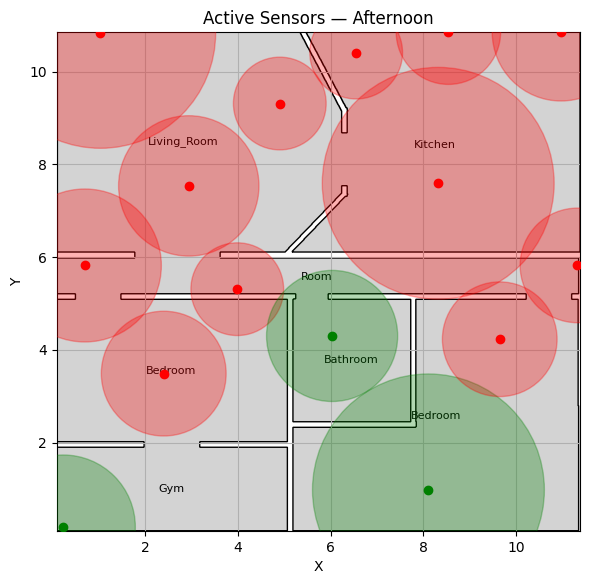

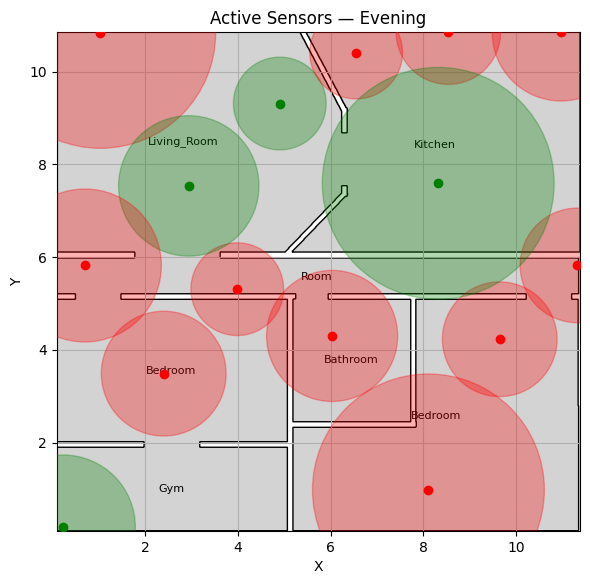

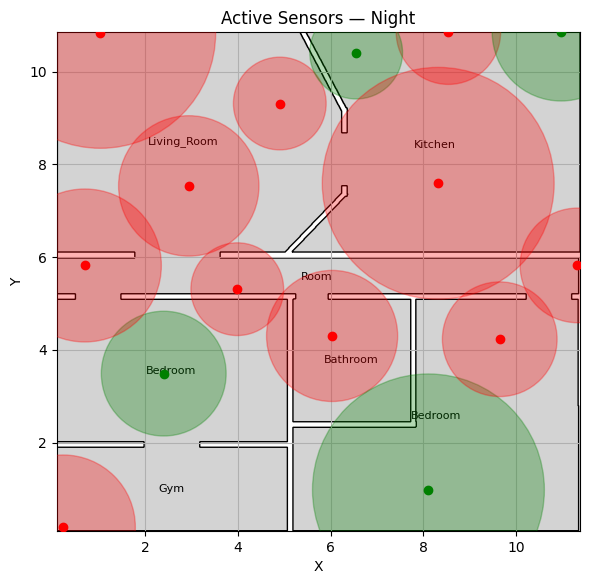

In [1]:
 #### Phase 2 PSO + GA
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pprint
import time 

# ------------ Load Layout and Sensor Data ------------
# Step 1: Read the saved filename
with open("selected_layout.txt", "r") as f:
    selected_file = f.read().strip()

layout_path = os.path.join("houseexpo_layouts", selected_file)

# Step 2: Load the layout again
with open(layout_path, "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
room_boxes     = layout_data["room_category"]
min_x, min_y   = layout_data["bbox"]["min"]
max_x, max_y   = layout_data["bbox"]["max"]

# Step 3: Load Phase 1 sensor positions
with open("phase1_sensors.json", "r") as f:
    sensor_data = json.load(f)

sensor_positions = np.array(sensor_data["sensors"])  # [x, y, r]

# ------------ Activity Levels Prompt ------------
time_blocks = ["Morning", "Afternoon", "Evening", "Night"]
activity_levels = {t: {} for t in time_blocks}
print("Enter activity levels (0.0–1.0):")
for t in time_blocks:
    print(f"\n– {t}")
    for room in room_boxes:
        while True:
            try:
                v = float(input(f"  {room}: "))
                if 0.0 <= v <= 1.0:
                    activity_levels[t][room] = v
                    break
            except ValueError:
                pass
            print("   → Enter a number between 0.0 and 1.0.")
print("\nFinal activity levels:")
pprint.pprint(activity_levels)

# ------------ Prepare Grid & Labels ------------
grid_res = 0.2
xs = np.arange(min_x, max_x, grid_res)
ys = np.arange(min_y, max_y, grid_res)
xx, yy = np.meshgrid(xs, ys)
GRID = np.c_[xx.ravel(), yy.ravel()]

room_label_map = np.full(len(GRID), "", dtype=object)
for room, boxes in room_boxes.items():
    for x1,y1,x2,y2 in boxes:
        m = (GRID[:,0]>=x1)&(GRID[:,0]<=x2)&(GRID[:,1]>=y1)&(GRID[:,1]<=y2)
        room_label_map[m] = room

# ------------ Activation Evaluation ------------
def evaluate_mask(mask, tkey):
    cov = np.zeros(len(GRID), dtype=float)
    for i,on in enumerate(mask):
        if not on: continue
        x0,y0,r = sensor_positions[i]
        d = np.hypot(GRID[:,0]-x0, GRID[:,1]-y0)
        cov += (d<=r).astype(float)
    weights = np.array([activity_levels[tkey].get(rm,0.0) for rm in room_label_map])
    weighted_cov = np.sum((cov>0)*weights)
    cost = np.sum(mask)
    overlap = np.sum(cov) - np.sum(cov>0)
    return weighted_cov, cost, overlap

# ------------ PSO + GA Optimization ------------
def optimize_activation_pso_ga(time_key,
                                swarm_size=30,
                                max_iter=50,
                                w=0.7,
                                c1=1.5,
                                c2=1.5,
                                beta=1.0,
                                ga_pop=20,
                                ga_gen=30,
                                ga_crossover=0.8,
                                ga_mutation=0.1):
    N = len(sensor_positions)
    # Initialize binary swarm and velocity
    pos = np.random.randint(0,2,(swarm_size,N))
    vel = np.zeros((swarm_size,N), dtype=float)
    pbest = pos.copy()
    pbest_val = np.full(swarm_size, np.inf)
    gbest = pos[0].copy()
    gbest_val = np.inf

    # PSO global search
    for _ in range(max_iter):
        for i in range(swarm_size):
            mask = pos[i].astype(bool)
            cov,cost,ov = evaluate_mask(mask, time_key)
            fitness = (cost + beta*ov)/(cov + 1e-6)
            if fitness < pbest_val[i]:
                pbest_val[i] = fitness
                pbest[i] = pos[i].copy()
            if fitness < gbest_val:
                gbest_val = fitness
                gbest = pos[i].copy()
        # PSO velocity & position update (binary)
        r1 = np.random.rand(swarm_size,N)
        r2 = np.random.rand(swarm_size,N)
        vel = w*vel + c1*r1*(pbest-pos) + c2*r2*(gbest-pos)
        prob = 1/(1+np.exp(-vel))
        pos = (np.random.rand(swarm_size,N) < prob).astype(int)

    # GA local refinement on gbest
    pop = [gbest.copy() for _ in range(ga_pop)]
    pop_fitness = []
    for ind in pop:
        cov,cost,ov = evaluate_mask(ind.astype(bool), time_key)
        pop_fitness.append((cost + beta*ov)/(cov + 1e-6))

    for _ in range(ga_gen):
        new_pop = []
        for _ in range(ga_pop//2):
            i1,i2 = np.random.choice(len(pop),2,replace=False)
            parent1 = pop[i1] if pop_fitness[i1] < pop_fitness[i2] else pop[i2]
            i3,i4 = np.random.choice(len(pop),2,replace=False)
            parent2 = pop[i3] if pop_fitness[i3] < pop_fitness[i4] else pop[i4]
            if np.random.rand() < ga_crossover:
                cx = np.random.randint(1, N)
                child1 = np.concatenate([parent1[:cx], parent2[cx:]])
                child2 = np.concatenate([parent2[:cx], parent1[cx:]])
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            for child in (child1, child2):
                for bit in range(N):
                    if np.random.rand() < ga_mutation:
                        child[bit] = 1 - child[bit]
                new_pop.append(child)
        pop = []
        pop_fitness = []
        for ind in new_pop:
            cov,cost,ov = evaluate_mask(ind.astype(bool), time_key)
            f = (cost + beta*ov)/(cov + 1e-6)
            pop.append(ind)
            pop_fitness.append(f)
    idx = int(np.argmin(pop_fitness))
    best_mask = pop[idx]
    return best_mask.astype(bool)

# ------------ Run & Save Phase 2 Results ------------
phase2 = {}
for t in time_blocks:
    start = time.perf_counter()
    mask = optimize_activation_pso_ga(t)
    duration = time.perf_counter() - start
    cov, cost, ov = evaluate_mask(mask, t)
    phase2[t] = {
        "active_mask": mask.tolist(),
        "active_count": int(cost),
        "weighted_coverage": float(cov),
        "overlap_penalty": float(ov),
        "runtime_s": round(duration, 3)
    }
    print(f"Time slot '{t}': PSO+GA runtime = {duration:.2f}s")

with open("phase2_results.json","w") as f:
    json.dump(phase2, f, indent=2)

# ------------ Visualization ------------
for t, data in phase2.items():
    mask = np.array(data["active_mask"])
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal'); ax.set_title(f"Active Sensors — {t}")
    ax.add_patch(Polygon(polygon_coords, closed=True, facecolor='lightgray', edgecolor='black', zorder=1))

    for room, boxes in room_boxes.items():
        if room.lower() == 'toilet':
            continue
        for x1, y1, x2, y2 in boxes:
            xc, yc = (x1 + x2)/2, (y1 + y2)/2
            ax.text(xc, yc, room, ha='center', va='center', fontsize=8, color='black', zorder=2)

    for i, on in enumerate(mask):
        x0, y0, r = sensor_positions[i]
        c = 'green' if on else 'red'
        ax.add_patch(plt.Circle((x0, y0), r, color=c, alpha=0.3, zorder=3))
        ax.plot(x0, y0, 'o', color=c, zorder=4)

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    ax.grid(True, zorder=0)
    ax.set_xlabel('X'); ax.set_ylabel('Y')
    plt.tight_layout(); plt.show()


     